# Prelude

In [1]:
from pyiron import Project
import matplotlib.pylab as plt
%config InlineBackend.figure_format = "retina"

/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2024-07-29/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import seaborn as sns

In [3]:
pr = Project("FreeElectron")

# Code

In [24]:
import scipy.integrate as sit
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
import scipy.interpolate as si
from scipy.special import entr
from scipy.constants import Boltzmann, eV
kB = Boltzmann / eV
import pandas as pd
from abc import ABC, abstractmethod

def integrate(y, x):
    if len(np.unique(np.diff(x))) == 1:
        return sit.romb(y, x[1] - x[0])
    else:               
        return sit.trapezoid(y=y, x=x)

def efermi(e, T, mu):
    if T != 0:
        return 1 / (1 + np.exp(( (e-mu)/kB/T)))
    else:
        return 1 * (e <= mu)

def occ(e, n, T, mu):
    f = efermi(e, T, mu)
    return integrate(f*n, e)

def find_mu(e, n, T, N, mu0=None):
    """
    Get Fermi energy from a given DOS at a given temperature following Fermi-Dirac distribution

    Args:
        e (np.array): Energies
        n (np.array): Frequencies / bin heights
        T (float): Temperature
        N (int): Number of electrons
        mu0 (float): Starting value for minimization

    Returns:
        (float): Fermi energy
    """
    if mu0 is None:
        mu0 = 0
    # https://journals.aps.org/prb/abstract/10.1103/PhysRevB.107.195122
    ret = so.minimize_scalar(lambda mu: (occ(e, n, T, mu) - N)**2, bracket=(e.min(), mu0, e.max()), tol=1e-7)
    # problematic: at low T
    # ret = so.basinhopping(lambda mu: (occ(e, n, T, mu[0]) - N)**2, x0=[mu0],
    #                       minimizer_kwargs={'bounds': [(e.min(), e.max())]})
    if ret.success:
        if abs(occ(e, n, T, ret.x) - N) > 0.01:
            print(f'Got {occ(e, n, T, ret.x)} instead of {N}!')
        return ret.x
    else:
        return mu0

def find_fermi(e, n, T, N, mu0=None):
    mu = find_mu(e, n, T, N, mu0=mu0)
    f = efermi(e, T, mu)
    return f, mu

def energy_entropy(e, n, f, mu, gamma=2):
    # factor 2 to account for two spin channels -> assumption density is *not* spin polarized
    s = entr(f) + entr(1-f) # eq. 9
    S = gamma * kB * integrate(n * s, e)  # eq. 8
    # U = integrate( n * (f - 1 * (e <= mu)) * e, e ) # eq. 7 This one works
    U = integrate( n * f * e, e ) - integrate(n[e<=mu] * e[e<=mu], e[e<=mu]) # This one doesn't
    # and we don't know why (Ali)
    return U, S

import dataclasses

@dataclasses.dataclass(frozen=True)
class Dos:
    energy: np.array
    density: np.array

    def fermi_distribution(self, T, mu):
        if T != 0:
            return 1 / (1 + np.exp(( (self.energy-mu)/kB/T)))
        else:
            return 1 * (self.energy <= mu)

    def occupation(T, mu):
        f = self.fermi_distribution(T, mu)
        return integrate(f*self.density, self.energy)



class DosMode(ABC):
    @abstractmethod
    def get_dos(self, job):
        pass
    
    @abstractmethod
    def __repr__(self):
        pass

class DOSCAR(DosMode):
    def get_dos(self, job):
        return (
            job.content['output/electronic_structure/dos/energies'], 
            job.content['output/electronic_structure/dos/tot_densities'][0]
        )
    
    def __repr__(self):
        return 'DOSCAR()'
    
class InterpolatedDOSCAR(DosMode):
    def __init__(self, npoints=10_000, method='slinear'):
        self.npoints = npoints
        self.method = method
        
    def get_dos(self, job):
        DOS = si.interp1d(
            job.content['output/electronic_structure/dos/energies'], 
            job.content['output/electronic_structure/dos/tot_densities'][0], 
            kind='cubic'
        )
        energy = np.linspace(
            job.content['output/electronic_structure/dos/energies'].min(),
            job.content['output/electronic_structure/dos/energies'].max(),
            10000
        )
        density = DOS(energy)
        return energy, density
    
    def __repr__(self):
        return f'InterpolatedDOSCAR({self.npoints}, {self.method})'
        
class Gaussian(DosMode):
    def __init__(self, smear=1e-1, npoints=5000):
        self.smear = smear
        self.npoints = npoints

    def _dos_gauss(self, e, w):
        ex = np.linspace(e.min()-1, e.max()+1, self.npoints)
        prefactor = 1/len(e)*1/np.sqrt(np.pi)/self.smear
        ediff = ex[:,np.newaxis,np.newaxis,np.newaxis]-e[np.newaxis, ...]
        return ex,  prefactor * (w * np.exp(-(ediff/self.smear)**2)).sum(axis=(1,2,3))
        
    def get_dos(self, job):
        eigenvals = job.content['output/generic/dft/bands/eig_matrix']
        NSPINS, NKPTS, NBANDS = eigenvals.shape
        # bring the weights in the same shape as eig values
        weights = job.content['output/electronic_structure/k_weights'].reshape(1, -1, 1)
        energy, density = self._dos_gauss(
            e=eigenvals, 
            w=weights,
        )
        # ensures integrate(density, energy) == NBANDS*NSPINS
        density *= (3 - NSPINS)
        return energy, density
    
    def __repr__(self):
        return f'SelfRolledGauss({self.smear}, {self.npoints})'

# METHOD A

In [5]:
al = pr.create.structure.bulk('Al', cubic=True)

In [6]:
def run(pr, name, structure, T):
    j = pr.create.job.Vasp([name, 'T', T])
    if not j.status.initialized: return j
    j.structure = structure
    j.input.incar['ISMEAR'] = -1
    j.input.incar['SIGMA'] = kB * T
    j.input.incar['NEDOS'] = 5000
    j.set_encut(400) # blazej SFE paper
    j.set_kpoints([34]*3)
    j.calc_static()
    j.server.queue = 's_cmmg'
    j.server.cores = 32
    j.server.run_time = 10*60
    j.run()
    return j

In [7]:
Ts = [1, 150, 300, 450, 600, 750, 900]

In [12]:
for T in Ts:
    j = run(pr.create_group('METHODA'), 'Al', al, T)

The job Al_T_1 was saved and received the ID: 23311794
Queue system id:  9064093


Compare the difference in eigenvalues when setting different smearing explicitely.  As argued in Xie's paper this seems to have purely a numerical effect.  0.0001 maybe Vasp's output fidelity.

In [22]:
j300 = pr['METHODA'].load('Al_T_300')
j900 = pr['METHODA'].load('Al_T_900')

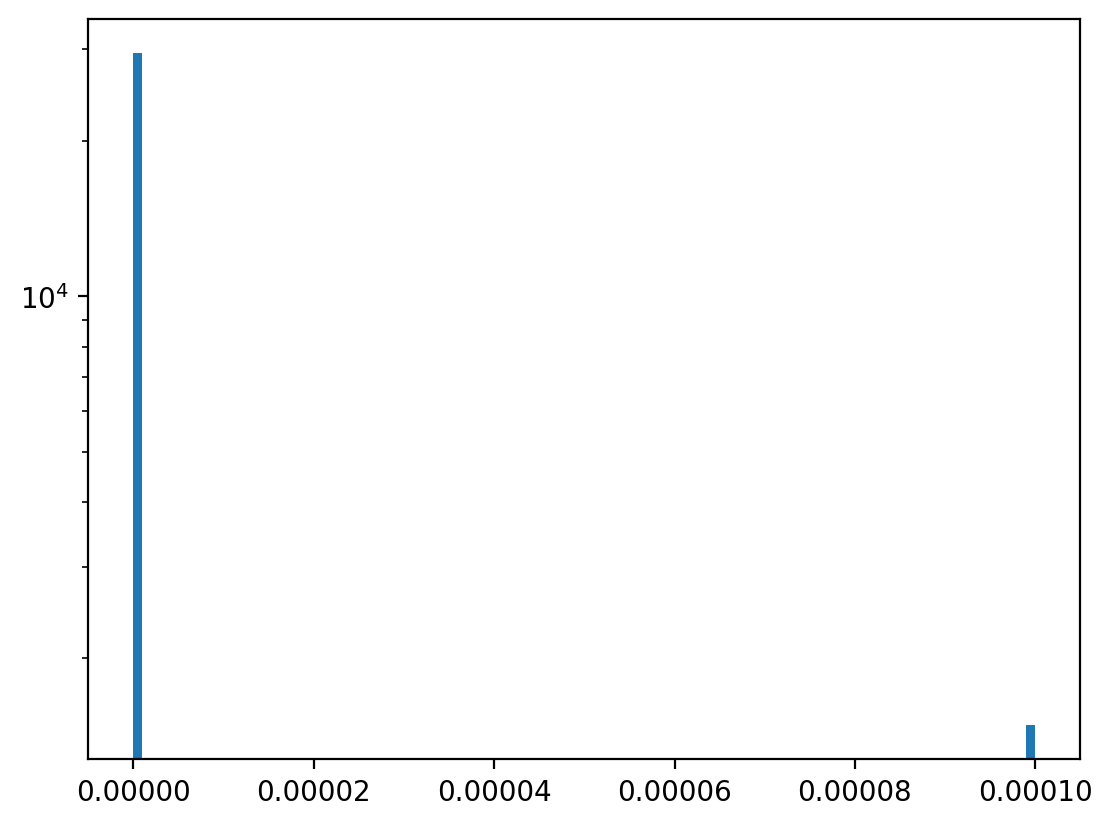

In [25]:
plt.hist(( j300.content['output/electronic_structure/eig_matrix']-j900.content['output/electronic_structure/eig_matrix'] ).ravel(),
        log=True, bins=100);

In [8]:
tab = pr['METHODA'].create.table('Table', delete_existing_job=True)
tab.add['F'] = lambda j: j.content['output/generic/dft/energy_free'][-1]
tab.add['E0'] = lambda j: j.content['output/generic/dft/energy_zero'][-1]
tab.add.get_total_number_of_atoms
tab.add.get_sigma
tab.run()
df = tab.get_dataframe()

The job Table was saved and received the ID: 23311797


Loading and filtering jobs:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
df['f'] = df.F/df.Number_of_atoms
df['e0'] = df.E0/df.Number_of_atoms

In [10]:
df['fel'] = df.F - df.E0

In [11]:
df['T'] = df.sigma/kB

<Axes: xlabel='T', ylabel='fel'>

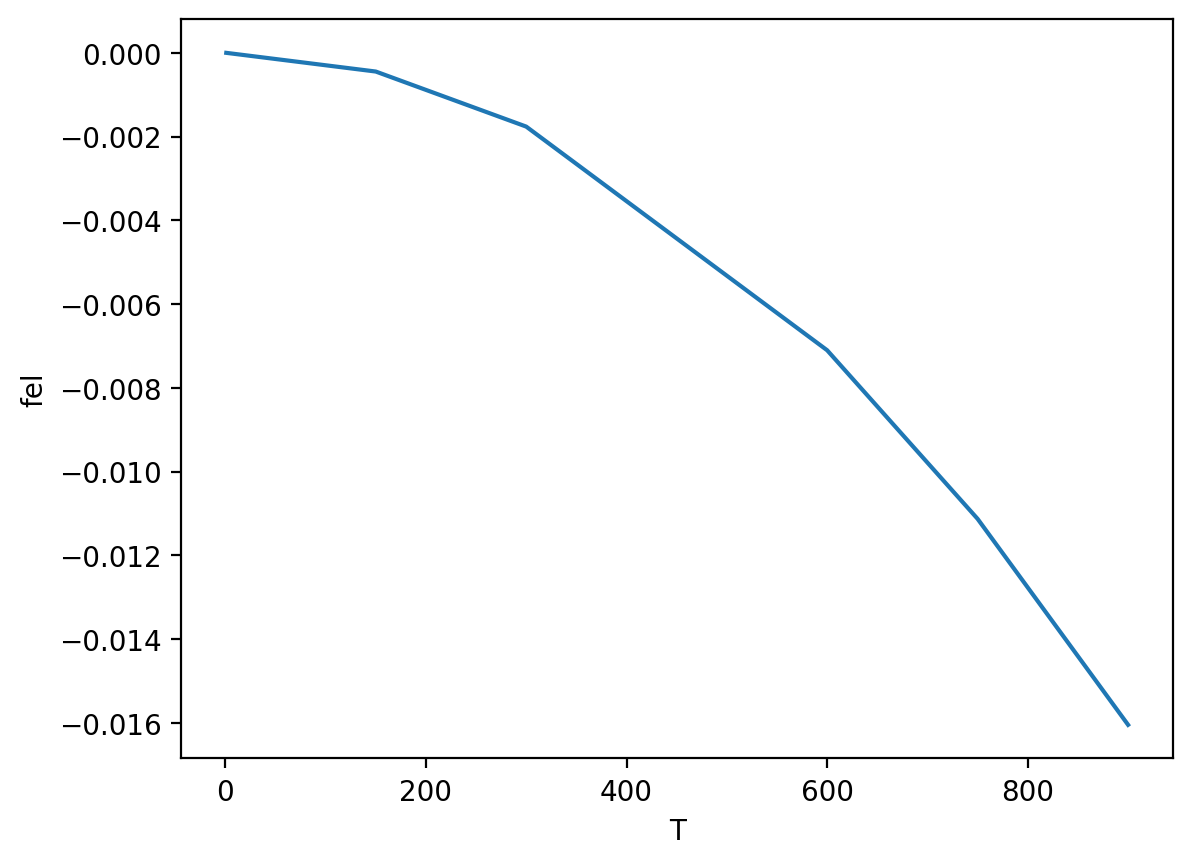

In [12]:
sns.lineplot(
    data=df,
    x='T', y='fel'
)

# METHOD B

In the fixed DOS approx.
1. run a single DFT calculation at any smearing
1. obtained smeared DOS from these eigenvalues directly (with what smearing parameters?)
2. apply Fermi-Dirac at any desired temperature to this DOS to get F for the electrons

## Load Some Vasp Job

In [13]:
job = pr.load("Al_T_900")

## 1. Obtain DOS

Compare DOS from DOSCAR and our own code.

Seems to work.

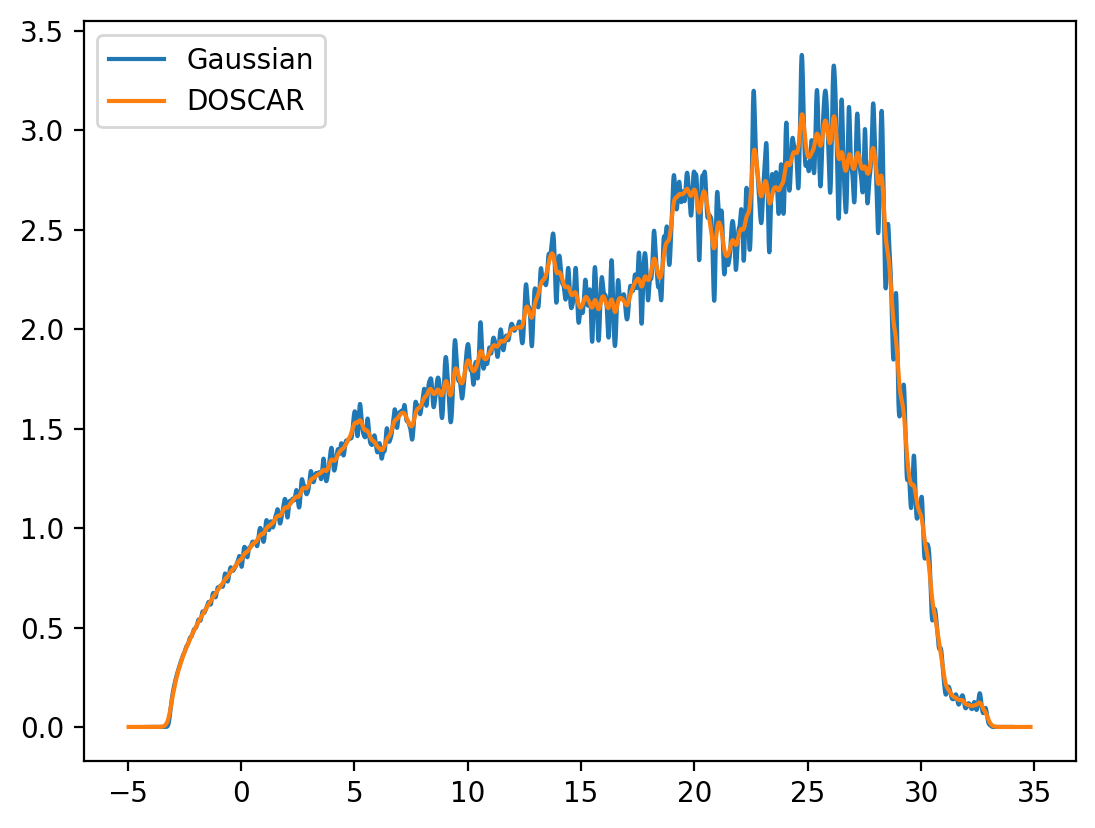

In [14]:
dos = Gaussian(
    smear=job.input.incar.get('SIGMA'),
    # npoints=job.input.incar.get('NEDOS', 300)
    npoints=10000
)
plt.plot(*dos.get_dos(job), label='Gaussian')
dos = DOSCAR()
plt.plot(*dos.get_dos(job), label='DOSCAR')
plt.legend()

This paper argues Fermi smearing and Gaussian smearing are equivalent when using Fermi sigma * 2.565 for Gaussian smearing and it appears to be correct.

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.107.195122

(For T=1K job this does not hold, but my implementation may be numerically unstable then.)

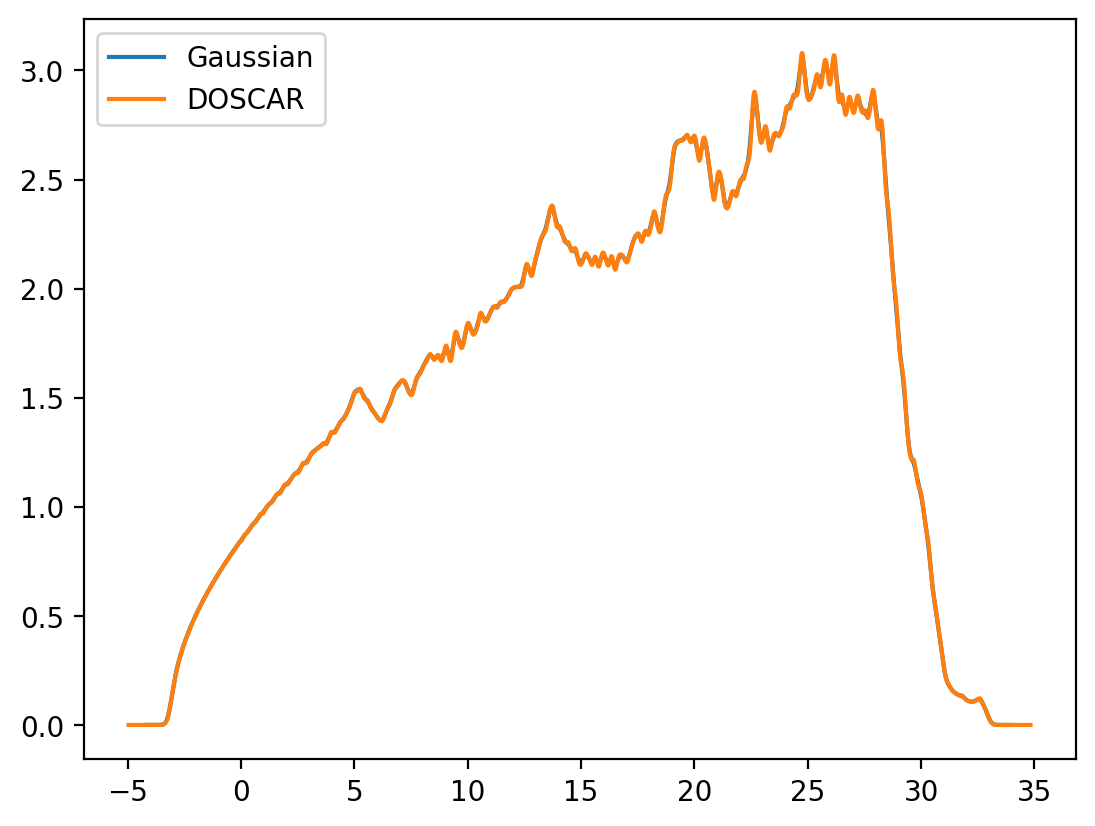

In [15]:
dos = Gaussian(
    smear=job.input.incar.get('SIGMA') * 2.565, 
    # npoints=job.input.incar.get('NEDOS', 300)
    npoints=10000,
)
plt.plot(*dos.get_dos(job), label='Gaussian')
dos = DOSCAR()
plt.plot(*dos.get_dos(job), label='DOSCAR')
plt.legend()

## Apply Fermi-Dirac

To to that we need to find the Fermi energy first.  The function `occ` gives the total number of electrons in a DOS given a chemical potential/temperature.  The function `find_mu` uses it to determine the chemical potential at a given T.  Below we see that we find generally the same fermi energy as VASP itself during SCF, so this code seems to work.

In [16]:
e, n = Gaussian(.1, 5000).get_dos(job)

In [17]:
N = job.get_nelect()

In [18]:
minimand = lambda mu, T: (occ(e, n, T, mu) - N)**2

In [19]:
mus = np.linspace(e.min(), e.max(), 1000)
mus = np.linspace(7.6, 8.1)

/tmp/ipykernel_39692/2321318195.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(( (e-mu)/kB/T)))


Text(0, 0.5, 'Squared deviation from nominal number of electrons')

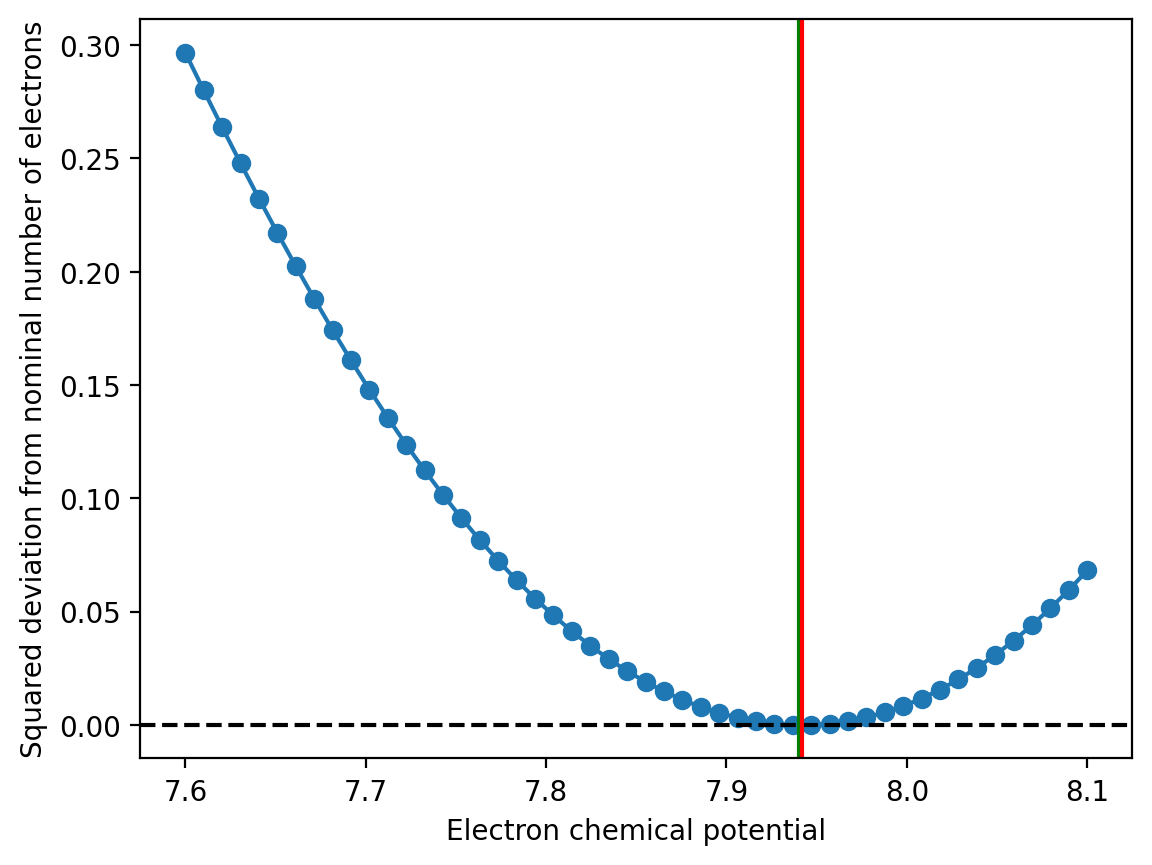

In [20]:
T = 100 # temperature to find the chemical potential
plt.plot(mus, [minimand(m, T) for m in mus], 'o-')
plt.axhline(0, c='k', ls='--')
plt.axvline(job.content['output/electronic_structure/efermi'], c='g')
plt.axvline(find_mu(e, n, T, job.get_nelect()), c='r')
plt.xlabel("Electron chemical potential")
plt.ylabel("Squared deviation from nominal number of electrons")

## Electronic Energies

We should have everything now to implement Xie's equations, and I tried in the functions `energy_entropy` and `electronic_entropy_from_job`, but see below there's a large offset and also different slope.
Since everything before that works, I likely get the formulas wrong.  Probably good idea to check Blazej's scripts in detail for them.

In [25]:
def electronic_entropy_from_job(j, Ts, mode=DOSCAR()):
    # pre tabulated DOS sucks, unless you happened to have set a high NEDOS
    energy, density = mode.get_dos(j)
    def iter(T):
        f, mu = find_fermi(energy, density, T, j.get_nelect(),
                           mu0=j.content['output/electronic_structure/efermi'])
        U, S = energy_entropy(energy, density, f, mu)
        return {'T': T, 'U': U, 'S': S, 'mu': mu}
    df = pd.DataFrame([iter(T) for T in Ts])
    df['s'] = df.S/len(j.structure)
    df['u'] = df.U/len(j.structure)
    df['TS'] = df['T'] * df['S']
    df['Ts'] = df['T'] * df['s']
    df['Fel'] = df.U - df.TS
    df['fel'] = df.u - df.Ts
    return df

In [28]:
odf = electronic_entropy_from_job(job, np.linspace(0, 900, 40), mode=Gaussian(.1, 5000))

/tmp/ipykernel_39692/2731264028.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(( (e-mu)/kB/T)))


<Axes: xlabel='T', ylabel='fel'>

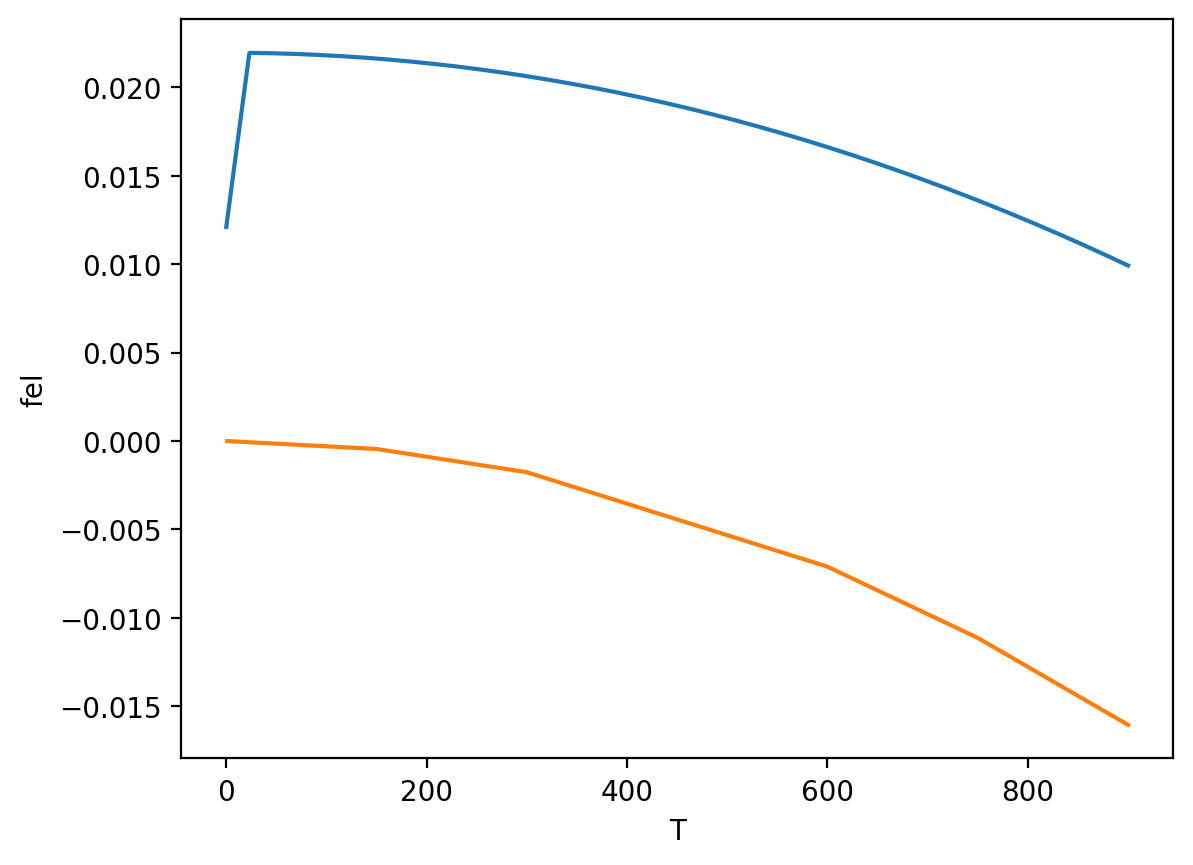

In [29]:
sns.lineplot(
    data=odf,
    x='T', y='fel'
)
sns.lineplot(
    data=df,
    x='T', y='fel'
)

<Axes: xlabel='T', ylabel='mu'>

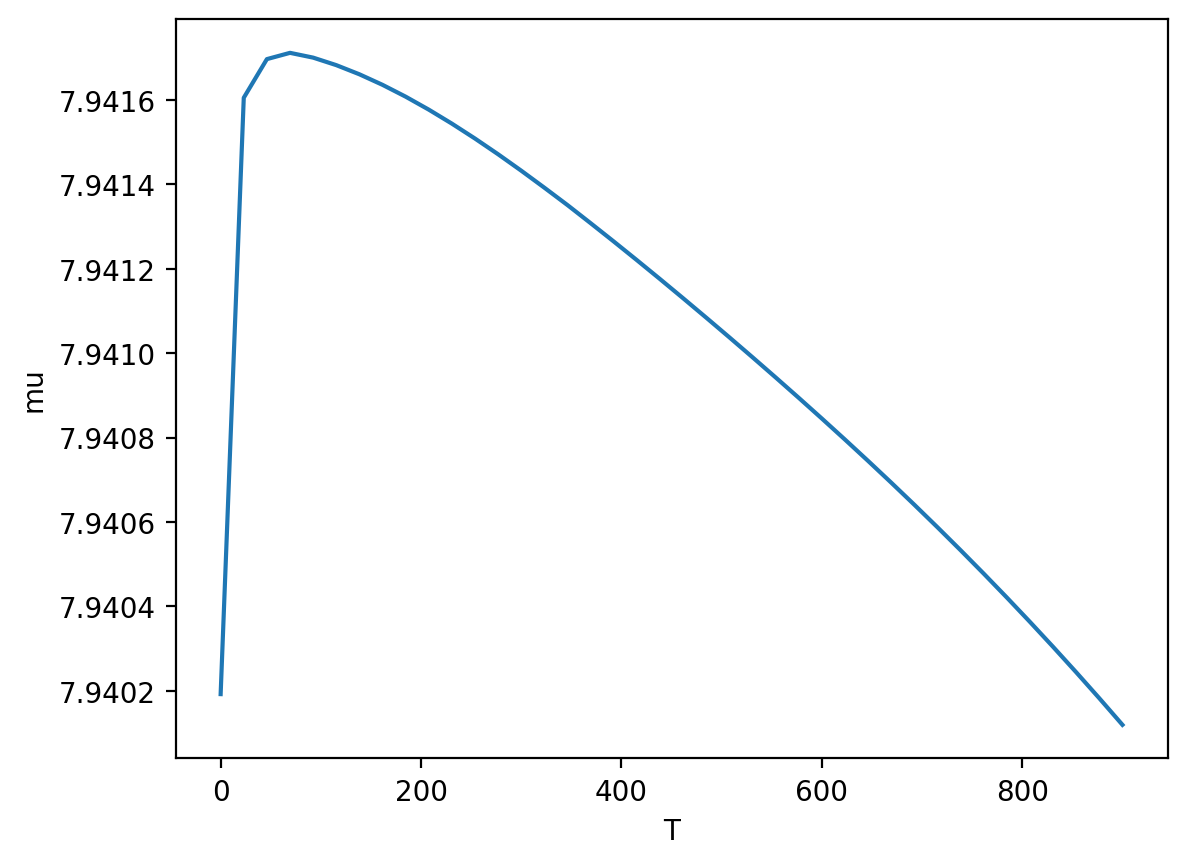

In [47]:
sns.lineplot(
    data=odf,
    x='T', y='mu'
)